In [2]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm

In [3]:
# Function to get market data and calculate volatility
def get_stock_data_and_volatility(ticker):
    data = yf.Ticker(ticker).history(period="1y")["Close"]
    daily_return = data.pct_change().dropna()
    sigma = daily_return.std() * np.sqrt(252)  # Annualized volatility
    S = data[-1]  # Current stock price
    return S, sigma

In [4]:
# ----------------------- Monte Carlo Lookback Put Option Simulation ----------------------- #

def simulate_lookback_put_price_and_graph(P0, r, sigma, T, N, n):
    dt = T / n
    discount_factor = np.exp(-r * T)

    max_prices = np.zeros(N)
    paths = np.zeros((N, n + 1))

    for i in range(N):
        S = P0
        max_price = P0
        paths[i, 0] = S

        for k in range(1, n + 1):
            u = np.random.normal((r - 0.5 * sigma**2) * dt, sigma * np.sqrt(dt))
            S = S * np.exp(u)
            paths[i, k] = S
            max_price = max(max_price, S)

        max_prices[i] = max_price

    average_max_price = np.mean(max_prices)
    lookback_put_price = discount_factor * (average_max_price - P0)

    plt.figure(figsize=(12, 6))
    for i in range(min(10, N)):
        plt.plot(np.linspace(0, T, n + 1), paths[i])
    plt.title('Sample Paths for Lookback Put Option')
    plt.xlabel('Time (years)')
    plt.ylabel('Stock Price')
    plt.grid(True)
    plt.show()

    return lookback_put_price

In [5]:
# ----------------------- Monte Carlo Shout Option Simulation ----------------------- #

def simulate_shout_option_price_and_graph(P0, K, r, sigma, T, option_type, N, n):
    dt = T / n
    discount_factor = np.exp(-r * T)

    payoffs = np.zeros(N)
    paths = np.zeros((N, n + 1))

    for i in range(N):
        S = P0
        paths[i, 0] = S
        shout_value = 0

        for k in range(1, n + 1):
            u = np.random.normal((r - 0.5 * sigma**2) * dt, sigma * np.sqrt(dt))
            S = S * np.exp(u)
            paths[i, k] = S

            if option_type == 'call':
                shout_value = max(shout_value, max(S - K, 0))
            else:
                shout_value = max(shout_value, max(K - S, 0))

        final_intrinsic_value = max(S - K, 0) if option_type == 'call' else max(K - S, 0)
        payoffs[i] = max(shout_value, final_intrinsic_value)

    average_payoff = np.mean(payoffs)
    shout_option_price = discount_factor * average_payoff

    plt.figure(figsize=(12, 6))
    for i in range(min(10, N)):
        plt.plot(np.linspace(0, T, n + 1), paths[i])
    plt.title(f'Sample Paths for Shout {option_type.capitalize()} Option')
    plt.xlabel('Time (years)')
    plt.ylabel('Stock Price')
    plt.grid(True)
    plt.show()

    return shout_option_price

In [6]:
# ----------------------- Binomial Tree for Shout Options ----------------------- #

def binomial_tree_shout_option_price(S, K, T, r, sigma, shout_price, option_type="Call", steps=100, plot_tree=False):
    dt = T / steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    stock_prices = np.zeros((steps + 1, steps + 1))
    option_values = np.zeros((steps + 1, steps + 1))

    for i in range(steps + 1):
        for j in range(i + 1):
            stock_prices[j, i] = S * (u ** (i - j)) * (d ** j)

    for i in range(steps, -1, -1):
        for j in range(i + 1):
            if i == steps:
                option_values[j, i] = max(stock_prices[j, i] - K, 0) if option_type == "Call" else max(K - stock_prices[j, i], 0)
            else:
                hold_value = np.exp(-r * dt) * (p * option_values[j, i + 1] + (1 - p) * option_values[j + 1, i + 1])
                shout_value = max(stock_prices[j, i] - K, 0) if option_type == "Call" else max(K - stock_prices[j, i], 0)
                option_values[j, i] = max(hold_value, shout_value)

    if plot_tree:
        plt.figure(figsize=(12, 8))
        for i in range(steps + 1):
            for j in range(i + 1):
                plt.scatter([i], [stock_prices[j, i]], color='blue')
                if i != steps:
                    plt.text(i, stock_prices[j, i], f"{option_values[j, i]:.2f}", color='red')

        plt.title('Binomial Tree for Shout Option')
        plt.xlabel('Step')
        plt.ylabel('Stock Price / Option Value')
        plt.grid(True)
        plt.show()

    return option_values[0, 0]

In [7]:
def trinomial_tree_shout_option_price(S, K, T, r, sigma, shout_price, option_type, steps, plot_tree=True):
    # Time and price increments
    dt = T / steps
    u = np.exp(sigma * np.sqrt(2 * dt))  # Up factor
    d = 1 / u  # Down factor
    m = 1  # Neutral factor

    # Probabilities for up, down, and neutral movement
    pu = ((np.exp(r * dt / 2) - np.exp(-sigma * np.sqrt(dt / 2))) / 
          (np.exp(sigma * np.sqrt(dt / 2)) - np.exp(-sigma * np.sqrt(dt / 2)))) ** 2
    pd = ((np.exp(sigma * np.sqrt(dt / 2)) - np.exp(r * dt / 2)) / 
          (np.exp(sigma * np.sqrt(dt / 2)) - np.exp(-sigma * np.sqrt(dt / 2)))) ** 2
    pm = 1 - pu - pd

    # Initializing arrays for stock prices and option values
    stock_prices = np.zeros((2 * steps + 1, steps + 1))
    option_values = np.zeros((2 * steps + 1, steps + 1))

    # Filling in stock prices in the trinomial tree
    for i in range(steps + 1):
        for j in range(2 * i + 1):
            stock_prices[j, i] = S * (u ** max(i - j, 0)) * (m ** (2 * min(j, i) - i)) * (d ** max(j - i, 0))

    # Backward calculation of option values
    for i in range(steps, -1, -1):
        for j in range(2 * i + 1):
            if i == steps:
                # Terminal condition: payout at maturity
                option_values[j, i] = max(stock_prices[j, i] - K, 0) if option_type == "Call" else max(K - stock_prices[j, i], 0)
            else:
                # Calculate hold value and shout value, choose the maximum
                hold_value = np.exp(-r * dt) * (pu * option_values[j, i + 1] + pm * option_values[j + 1, i + 1] + pd * option_values[j + 2, i + 1])
                shout_value = max(stock_prices[j, i] - K, 0) if option_type == "Call" else max(K - stock_prices[j, i], 0)
                option_values[j, i] = max(hold_value, shout_value)

    if plot_tree:
        # Plotting the trinomial tree for visualization
        plt.figure(figsize=(12, 8))
        for i in range(steps + 1):
            for j in range(2 * i + 1):
                plt.scatter([i], [stock_prices[j, i]], color='blue')
                if i != steps: 
                    plt.text(i, stock_prices[j, i], f"{option_values[j, i]:.2f}", color='red', fontsize=8)

        plt.title('Trinomial Tree for Shout Option')
        plt.xlabel('Step')
        plt.ylabel('Stock Price / Option Value')
        plt.grid(True)
        plt.show()

    return option_values[0, 0]

In [11]:
# ----------------------- To see the difference : Black & Scholes Model ----------------------- #

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def shout_call_option_price(S0, St, K, r, T, sigma):
    present_value_profit = np.maximum(St - K, 0) * np.exp(-r * T)
    european_call_value = black_scholes_call(St, K, T, r, sigma)
    shout_call_price = present_value_profit + european_call_value
    return shout_call_price

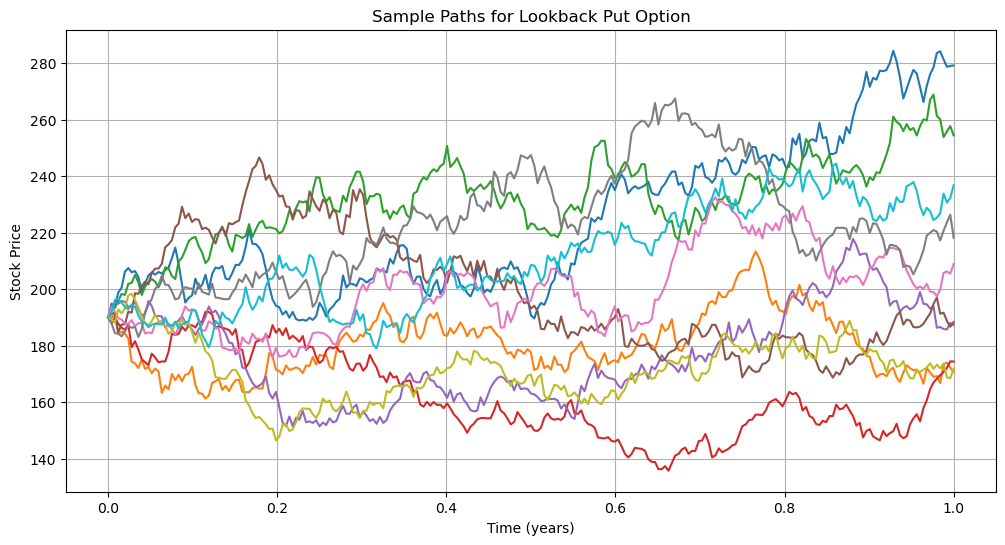

For the Monte Carlo model on the Lookback Put Option Price, we estimated : 36.49459202504237


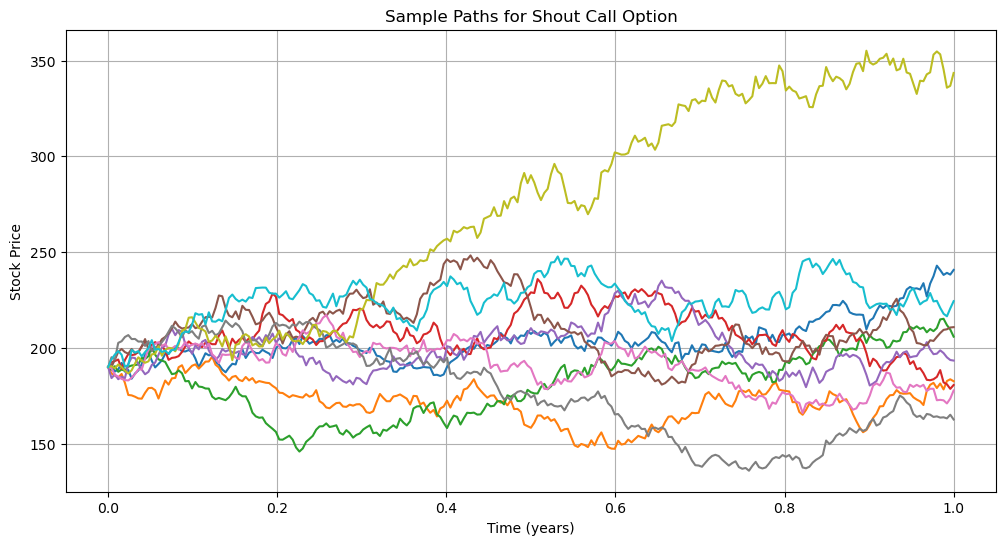

For the Monte Carlo model on the Shout Call Option Price, we estimated : 40.570006313316874


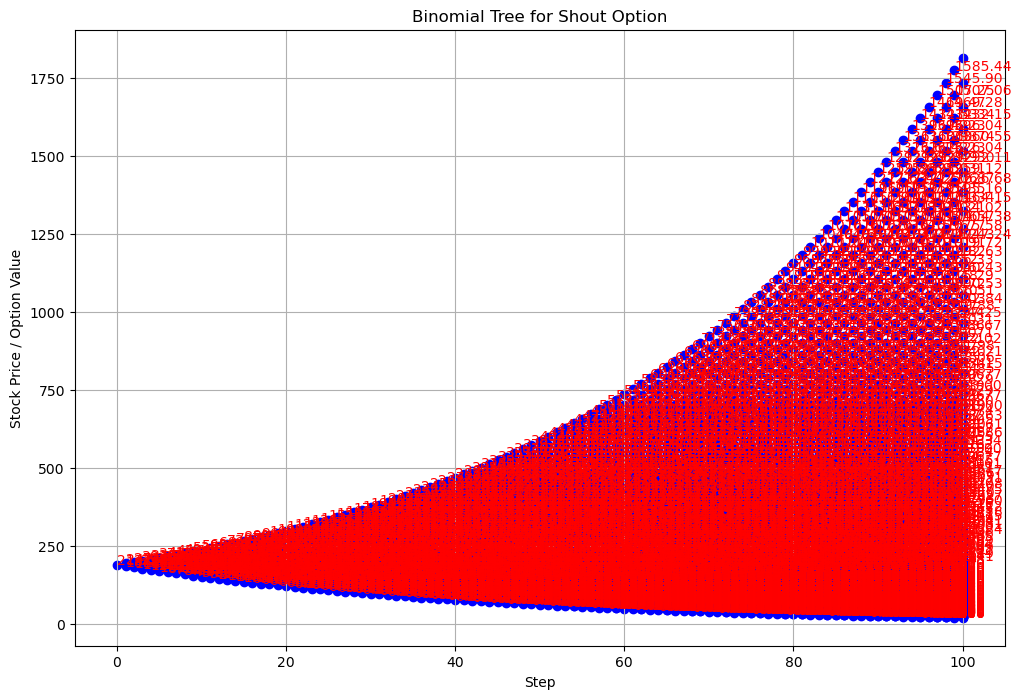

For the Binomial Tree on the Shout Call Price for AAPL, we estimated: 21.650879773478614


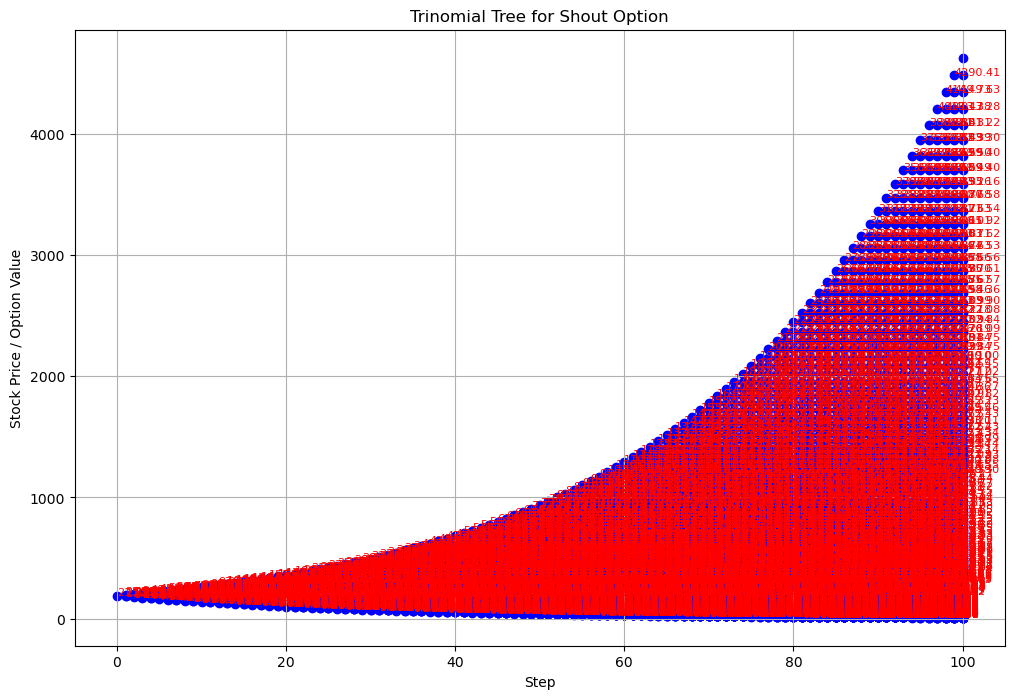

For the Trinomial Tree on the Shout Call Price for AAPL, we estimated: 21.67214021686045
To compare, we estimated on the Shout Call Option Price for AAPL with Black & Scholes: 21.693427756245924


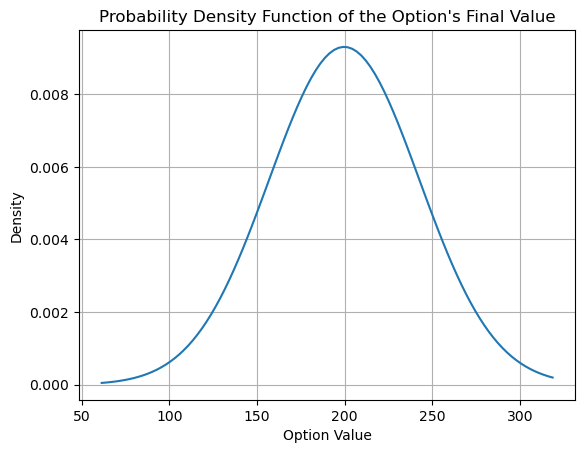

In [12]:
# ----------------------- Example Usage and Plotting ----------------------- #

ticker = "AAPL"
S, sigma = get_stock_data_and_volatility(ticker)
r = 0.05
T = 1
N = 1000
n = 252
steps=100 #it was change to 1000 to compare the methods but it's very long to compute so, we kept only 100 steps here.
shout_price = S * 1.1
K = S

lookback_put_price = simulate_lookback_put_price_and_graph(S, r, sigma, T, N, n)
print("For the Monte Carlo model on the Lookback Put Option Price, we estimated :", lookback_put_price)

shout_call_price = simulate_shout_option_price_and_graph(S, K, r, sigma, T, 'call', N, n)
print("For the Monte Carlo model on the Shout Call Option Price, we estimated :", shout_call_price)

option_type = "Call"
binom_call_price = binomial_tree_shout_option_price(S, K, T, r, sigma, shout_price, option_type, steps, plot_tree=True)
print(f"For the Binomial Tree on the Shout Call Price for {ticker}, we estimated: {binom_call_price}")

option_price = trinomial_tree_shout_option_price(S, K, T, r, sigma, shout_price, option_type, steps, plot_tree=True)
print(f"For the Trinomial Tree on the Shout Call Price for {ticker}, we estimated: {option_price}")

St = S
shout_price = shout_call_option_price(S, St, K, r, T, sigma)
print(f"To compare, we estimated on the Shout Call Option Price for {ticker} with Black & Scholes: {shout_price}")

# The probability density function
std_dev = S * sigma * np.sqrt(T)
x = np.linspace(max(0, S - 3 * std_dev), S + 3 * std_dev, 100)
pdf = norm.pdf(x, S * np.exp(r * T), std_dev)
plt.plot(x, pdf)
plt.title('Probability Density Function of the Option\'s Final Value')
plt.xlabel('Option Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()